In [1]:
#%tensorflow_version 1.x

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from tqdm import tqdm
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)



from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#gpu_options = tf.GPUOptions(allow_growth=True)
#session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))




C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

1 Physical GPUs, 1 Logical GPUs


Using TensorFlow backend.


In [ ]:
train_ti_ids = []

for (root,dirs,files) in os.walk("C:\MonuSeg_Short\Training\TissueImages/"):
  for i in range( len(files)):  
    train_ti_ids.append(files[i])


train_gt_ids = []

for i in range( len(train_ti_ids) ):
    #print(i)
    #print( train_ti_ids[i] )
    my_str = train_ti_ids[i]
    #substr = ".png"
    #inserttxt = "_bin_mask_"
    #idx = my_str.index(substr)
    #my_str = my_str[:idx]
    #s = my_str.split('_')
    #s = s[0] + inserttxt + s[1] + ".png"
    train_gt_ids.append(my_str)
    #print(my_str)

import pandas as pd

df1 = pd.DataFrame(train_ti_ids)
print(df1)
df2 = pd.DataFrame(train_gt_ids)
print(df2)


In [ ]:
test_ti_ids = []

for (root,dirs,files) in os.walk("C:\MonuSeg_Short\Test\TissueImages/"):
  for i in range( len(files)):  
    test_ti_ids.append(files[i])

test_gt_ids = []

for i in range( len(test_ti_ids) ):
    #print(i)
    #print( test_ti_ids[i] )
    my_str = test_ti_ids[i]
    #substr = ".png"
    #inserttxt = "_bin_mask_"
    #idx = my_str.index(substr)
    #my_str = my_str[:idx]
    #s = my_str.split('_')
    #s = s[0] + inserttxt + s[1] + ".png"
    test_gt_ids.append(my_str)
    #print(my_str)

import pandas as pd

df1 = pd.DataFrame(test_ti_ids)
print(df1)
df2 = pd.DataFrame(test_gt_ids)
print(df2)

In [ ]:
from IPython.display import clear_output

im_width = 256
im_height = 256
def con_img_array(ids, base_path):
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    for i in tqdm( (range(len(ids))) ):
        #print(ids[i])
        img = load_img( base_path + ids[i] , color_mode = "grayscale")
        x_img = img_to_array(img)
        x_img = resize(x_img, (256, 256, 1), mode = 'constant', preserve_range = True)
        X[i] = x_img/255.0
        #clear_output(wait=True)
    #print("=========================================")
    return X


X_train = con_img_array(train_ti_ids, "C:\MonuSeg_Short/Training/TissueImages/")
y_train = con_img_array(train_gt_ids, "C:\MonuSeg_Short/Training/GroundTruth/")
X_test = con_img_array(test_ti_ids, "C:\MonuSeg_Short/Test/TissueImages/")
y_test = con_img_array(test_gt_ids, "C:\MonuSeg_Short/Test/GroundTruth/")

In [ ]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

In [ ]:
from numpy import save
save('X_train_short.npy', X_train)
save('y_train_short.npy', y_train)
save('X_test_short.npy', X_test)
save('y_test_short.npy', y_test)

In [2]:
from numpy import load
# load array
X_train = load('X_train_short.npy')
y_train = load('y_train_short.npy')
X_test = load('X_test_short.npy')
y_test = load('y_test_short.npy')

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)


(1470, 256, 256, 1)
(1470, 256, 256, 1)
(686, 256, 256, 1)
(686, 256, 256, 1)


(-0.5, 255.5, 255.5, -0.5)

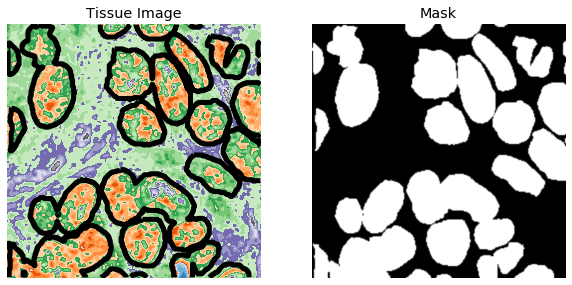

In [3]:
ix = 7


has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 7))

ax1.imshow(X_train[ix, ..., 0], cmap = 'tab20c', interpolation = 'bicubic')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Tissue Image')
ax1.axis('off')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bicubic')
ax2.set_title('Mask')
ax2.axis('off')

In [4]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [5]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [6]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


binary_crossentropy = "binary_crossentropy"
from keras import optimizers

RMS = optimizers.RMSprop()
sgd = optimizers.SGD(lr=0.01, clipnorm=1.)

input_img = Input((256, 256, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.03, batchnorm=True)
model.compile(optimizer= sgd, loss=[dice_coef_loss], metrics=["accuracy", f1_m, precision_m, recall_m, dice_coef])
#model.summary()

In [7]:
def scheduler(epoch):
  if epoch < 10:
    return 0.001

  else:
    return float(0.001 * tf.math.exp(0.1 * (10 - epoch)))


SCH = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks = [
     
    EarlyStopping(patience=100,   verbose=1),
    ReduceLROnPlateau(factor=0.1,  patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', monitor='val_loss',  save_best_only=True, save_weights_only=True, verbose=1)
]

In [8]:
#results = model.fit(X_train, y_train, batch_size=16, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test), verbose = 1)
results = model.fit(X_train, y_train, batch_size=32, epochs=300, callbacks=callbacks , validation_split=0.3 , verbose = 1)


Train on 1029 samples, validate on 441 samples
Epoch 1/300
1029/1029 [==============================] - 27s 26ms/step - loss: 0.1870 - accuracy: 0.4843 - f1_m: 0.4449 - precision_m: 0.3206 - recall_m: 0.7304 - dice_coef: 0.8130 - val_loss: 0.1565 - val_accuracy: 0.7440 - val_f1_m: 0.3746 - val_precision_m: 0.4423 - val_recall_m: 0.3331 - val_dice_coef: 0.8435

Epoch 00001: val_loss improved from inf to 0.15654, saving model to model-tgs-salt.h5
Epoch 2/300
1029/1029 [==============================] - 20s 19ms/step - loss: 0.1521 - accuracy: 0.6412 - f1_m: 0.5580 - precision_m: 0.4253 - recall_m: 0.8129 - dice_coef: 0.8479 - val_loss: 0.1361 - val_accuracy: 0.7970 - val_f1_m: 0.4062 - val_precision_m: 0.6091 - val_recall_m: 0.3479 - val_dice_coef: 0.8639

Epoch 00002: val_loss improved from 0.15654 to 0.13613, saving model to model-tgs-salt.h5
Epoch 3/300
1029/1029 [==============================] - 20s 19ms/step - loss: 0.1370 - accuracy: 0.7006 - f1_m: 0.5967 - precision_m: 0.4783 - 

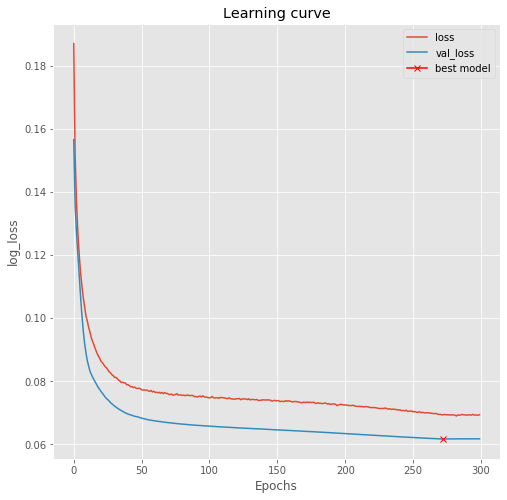

In [9]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();
plt.savefig("unet_loss.png")

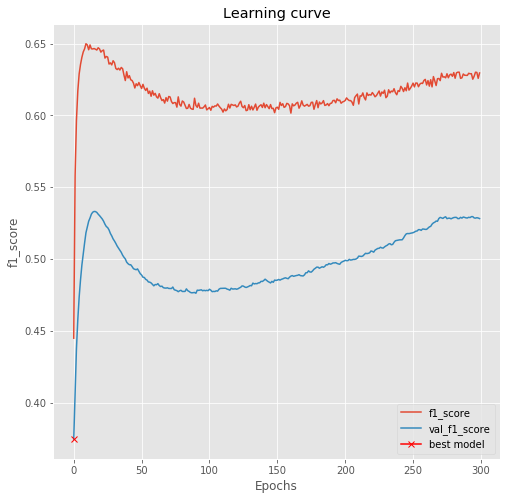

In [10]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["f1_m"], label="f1_score")
plt.plot(results.history["val_f1_m"], label="val_f1_score")
plt.plot( np.argmin(results.history["val_f1_m"]), np.min(results.history["val_f1_m"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("f1_score")
plt.legend();
plt.savefig("unet_f1.png")

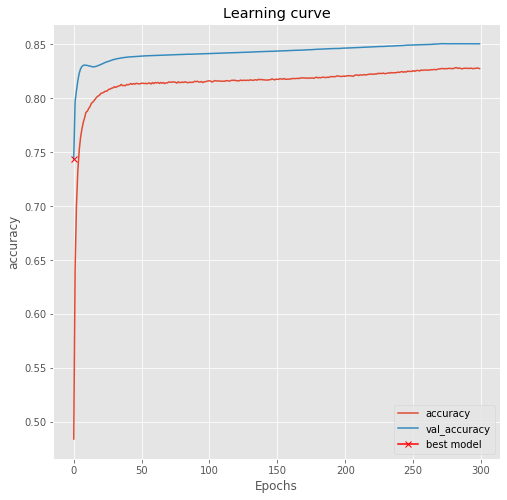

In [12]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmin(results.history["val_accuracy"]), np.min(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend();
plt.savefig("unet_accuracy.png")

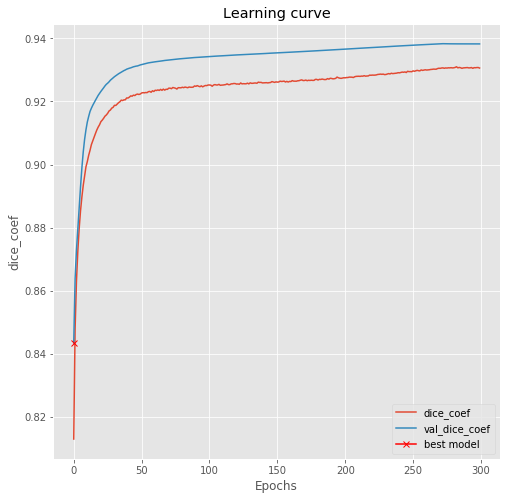

In [13]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["dice_coef"], label="dice_coef")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmin(results.history["val_dice_coef"]), np.min(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("dice_coef")
plt.legend();
plt.savefig("unet_dice_coef.png")

In [14]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [15]:
# Evaluate on validation set (this must be equals to the best log_loss)
loss, accuracy, f1_score, precision, recall , dice_score = model.evaluate(X_test, y_test, verbose=1)

print("unet_loss:", loss)
print("unet_Accuracy:", accuracy)
print("unet_f1_score:", f1_score)
#print("unet_precision:", precision)
#print("unet_recall:", recall)
print("unet_dice_score:", dice_score)


686/686 [==============================] - 4s 6ms/step
unet_loss: 0.0557007881929506
unet_Accuracy: 0.876026451587677
unet_f1_score: 0.7026073336601257
unet_dice_score: 0.9442992210388184


In [16]:
preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 5, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Tissue Image')
    ax[0].axis('off')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')
    ax[1].axis('off')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Tissue Image Predicted Mask')
    ax[2].axis('off')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    ax[3].set_title('Tissue Image Predicted binary');
    ax[3].axis('off')

    ax[4].imshow(y[ix].squeeze())
    if has_mask:
        ax[4].contour(binary_preds[ix].squeeze(), colors='k', levels=[0.5])
    ax[4].set_title('Prdicted Mask on Original')
    ax[4].axis('off')

686/686 [==============================] - 4s 6ms/step


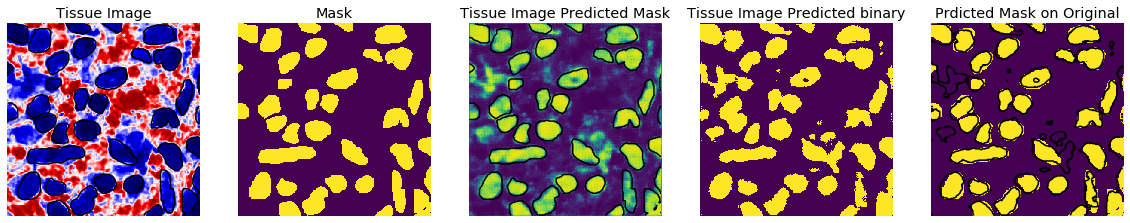

In [17]:
plot_sample(X_test, y_test, preds_test, preds_test_t)

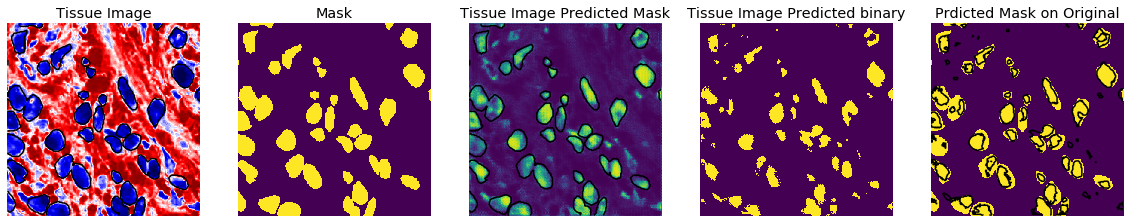

In [20]:
plot_sample(X_test, y_test, preds_test, preds_test_t)

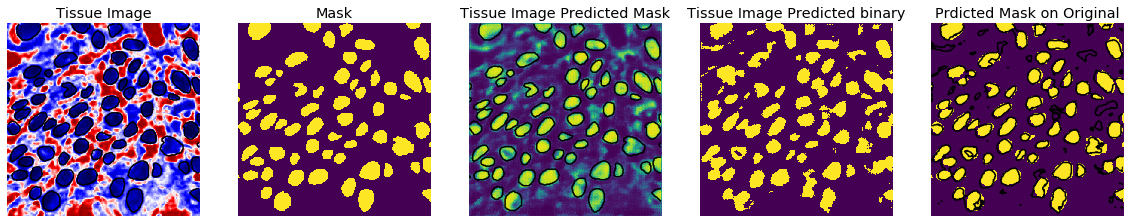

In [19]:
plot_sample(X_test, y_test, preds_test, preds_test_t)